In [1]:
# import
import os
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.cluster import KMeans

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import network_control functions
from network_control.energies import ComputeControlEnergy, integrate_u
from network_control.energies import optimal_input as get_control_inputs
from network_control.metrics import ave_control
from network_control.utils import matrix_normalization, convert_states_str2float, normalize_state
from network_control.plotting import roi_to_vtx

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/results'
A_file = 'pnc_schaefer200_Am.npy'
rsts_file = 'pnc_schaefer200_rsts.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


In [4]:
# normalize
A[np.eye(A.shape[0]).astype(bool)] = 0
A_norm = matrix_normalization(A, version='continuous', c=1)

In [5]:
# load resting-state time series
rsts = np.load(os.path.join(datadir, rsts_file))

n_trs = rsts.shape[0]
n_nodes_rsts = rsts.shape[1]
n_subs = rsts.shape[2]
print('n_trs, {0}; n_nodes, {1}; n_subs, {2}'.format(n_trs, n_nodes_rsts, n_subs))

rsts_concat = np.zeros((n_trs * n_subs, n_nodes_rsts))
print(rsts_concat.shape)

for i in np.arange(n_subs):
    # z score subject i's time series
    rsts_z = sp.stats.zscore(rsts[:, :, i], axis=0)

    start_idx = i * n_trs
    end_idx = start_idx + n_trs
    rsts_concat[start_idx:end_idx, :] = rsts_z

n_trs, 120; n_nodes, 200; n_subs, 253
(30360, 200)


(5, 200)
-0.6 0.6


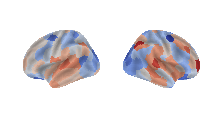

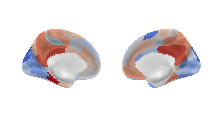

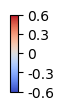

-1.5 1.5


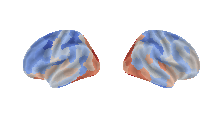

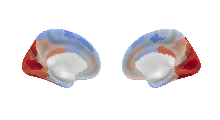

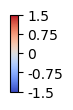

-1.2 1.2


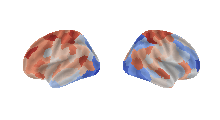

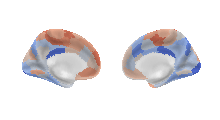

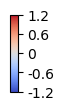

-1.4 1.4


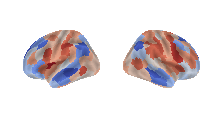

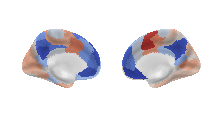

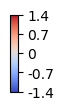

-1.2 1.2


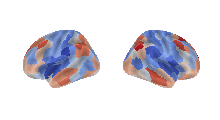

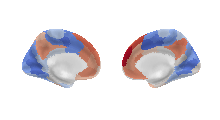

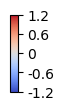

In [6]:
# extract 5 clusters of activity
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rsts_concat)

# extract cluster centers. These represent dominant patterns of recurrent activity over time
centroids = kmeans.cluster_centers_
print(centroids.shape)

# plot states on brain surface
lh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/lh.Schaefer2018_200Parcels_7Networks_order.annot'
rh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/rh.Schaefer2018_200Parcels_7Networks_order.annot'
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
cmap = 'coolwarm'

for i in np.arange(n_clusters):
    state = centroids[i, :]

    vmax = np.round(np.max(np.abs(state)), 1)
    vmin = -vmax
    print(vmin, vmax)

    vtx_data_lh, _, _ = roi_to_vtx(state[:int(n_nodes/2)], lh_annot_file)
    vtx_data_rh, _, _ = roi_to_vtx(state[int(n_nodes/2):], rh_annot_file)

    f, ax = plt.subplots(1, 2, figsize=(2, 2), subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data_lh,
                         hemi='left', view='lateral',
                         vmin=vmin, vmax=vmax,
                         bg_map=fsaverage['sulc_left'],
                         bg_on_data=True, axes=ax[0],
                         darkness=.5, cmap=cmap, colorbar=False)

    plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=vtx_data_rh,
                         hemi='right', view='lateral',
                         vmin=vmin, vmax=vmax,
                         bg_map=fsaverage['sulc_right'],
                         bg_on_data=True, axes=ax[1],
                         darkness=.5, cmap=cmap, colorbar=False)
    f.tight_layout(pad=0)
    f.savefig(os.path.join(resultsdir, 'cluster_{0}_lateral.png'.format(i)), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plotting.show()

    f, ax = plt.subplots(1, 2, figsize=(2, 2), subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data_lh,
                         hemi='left', view='medial',
                         vmin=vmin, vmax=vmax,
                         bg_map=fsaverage['sulc_left'],
                         bg_on_data=True, axes=ax[0],
                         darkness=.5, cmap=cmap, colorbar=False)

    plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=vtx_data_rh,
                         hemi='right', view='medial',
                         vmin=vmin, vmax=vmax,
                         bg_map=fsaverage['sulc_right'],
                         bg_on_data=True, axes=ax[1],
                         darkness=.5, cmap=cmap, colorbar=False)
    f.tight_layout(pad=0)
    f.savefig(os.path.join(resultsdir, 'cluster_{0}_medial.png'.format(i)), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plotting.show()

    # colorbar
    f, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data_lh,
                         hemi='left', view='lateral',
                         vmin=vmin, vmax=vmax,
                         bg_map=fsaverage['sulc_left'],
                         bg_on_data=True, axes=ax,
                         darkness=.5, cmap=cmap, colorbar=True, cbar_tick_format='%.2g')
    ax.set_visible(False)
    f.savefig(os.path.join(resultsdir, 'cluster_{0}_colorbar.svg'.format(i)), dpi=300, bbox_inches='tight', pad_inches=0.01)
    plotting.show()

In [7]:
# extract visual cluster is initial state
x0 = centroids[1, :]
# extract default mode cluster as target state
xf = centroids[4, :]

In [8]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

In [9]:
# specify a uniform full control: all nodes are control nodes
# and all control nodes are assigned equal control weight
B = np.eye(n_nodes)

In [10]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)

[   0  200  400  600  800 1000]


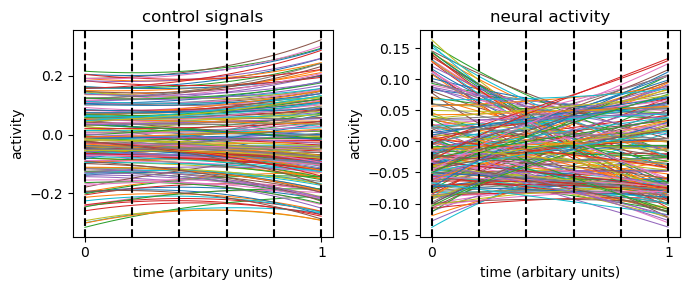

In [11]:
timepoints_to_plot = np.arange(0, x.shape[0], int(x.shape[0]/5))
print(timepoints_to_plot)

f, ax = plt.subplots(1, 2, figsize=(7, 3))
# plot control signals for initial state
ax[0].plot(u, linewidth=0.75)
ax[0].set_title('control signals')

# plot state trajectory for initial state
ax[1].plot(x, linewidth=0.75)
ax[1].set_title('neural activity')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (arbitary units)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

    for i in timepoints_to_plot:
        cax.axvline(x=i, color='black', linestyle='--')

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu_fmri.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [12]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)

# summarize nodal energy
energy = np.sum(node_energy)

print(energy)

2718.0096217104956


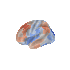

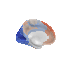

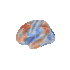

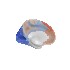

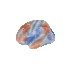

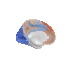

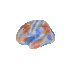

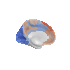

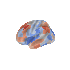

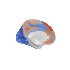

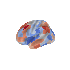

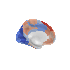

In [13]:
plot_u = True

for i in timepoints_to_plot:
    if plot_u:
        data = u[i, :]
        vmax = 0.3
        vmin = -0.3
        fig_label = 'u_t{0}'.format(i)
    else:
        data = x[i, :]
        vmax = 0.2
        vmin = -0.2
        fig_label = 'x_t{0}'.format(i)

    vtx_data, _, _ = roi_to_vtx(data[:int(n_nodes/2)], lh_annot_file)

    f, ax = plt.subplots(figsize=(.5, .5), subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data,
                           hemi='left', view='lateral',
                           vmin=vmin, vmax=vmax, center=0,
                           bg_map=fsaverage['sulc_left'],
                           bg_on_data=True, axes=ax,
                           darkness=.5, cmap=cmap, colorbar=False)
    f.tight_layout(pad=0)
    f.savefig(os.path.join(resultsdir, fig_label+'_lateral.png'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plotting.show()

    f, ax = plt.subplots(figsize=(.5, .5), subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=vtx_data,
                           hemi='left', view='medial',
                           vmin=vmin, vmax=vmax, center=0,
                           bg_map=fsaverage['sulc_left'],
                           bg_on_data=True, axes=ax,
                           darkness=.5, cmap=cmap, colorbar=False)
    f.tight_layout(pad=0)
    f.savefig(os.path.join(resultsdir, fig_label+'_medial.png'), dpi=600, bbox_inches='tight', pad_inches=0.01)
    plotting.show()